#### DATA602: Final project (Malware Classification)<br>
By Tyler Snow and Flo Doo

> Purpose: Given a  large dataset containing 1,804 features of computer viruses and a target (class) feature, we were tasked to find a supervised, classification model with the following goals:
  - Try different classification methods and apply best practices we have seen in the lectures such as grid search, cross validation, regularization, and etc.
  - Choose a model that will classify the virus as quickly as possible.

### **Step 1: Environment Setup**

In [ ]:
!pip install gdown
!pip install scikit-learn

In [ ]:
# Import libraries
import pandas as pd                   # For data handling
import numpy as np                    # For numerical operations
import matplotlib.pyplot as plt       # For plotting and visualization
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # For splitting data and hyperparameter tuning
from sklearn.preprocessing import StandardScaler  # For standardizing the features
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif  # For unsupervised and supervised feature selection
from sklearn.linear_model import LogisticRegression  # One classification model
from sklearn.tree import DecisionTreeClassifier # Another model
from sklearn.pipeline import Pipeline  # To create a modular pipeline combining preprocessing and modeling steps
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For evaluating the model's performance
from sklearn.impute import SimpleImputer # For filling missing values
from sklearn.decomposition import TruncatedSVD, PCA # For PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # For LDA
from sklearn.ensemble import VotingClassifier, RandomForestClassifier # For ensembling methods
import time # For tracking processing times

# Neural network library
import torch
from torch import nn
import torch.utils.data

### **Step 2: Dataset Download & EDA**
Using the provided Google Drive link (2nd link in instructions): [link](https://drive.google.com/uc?id=1cxP_1itbp_ziI-Q03Gu7akNd7CPIYsvz)

In [ ]:
import gdown

# Google Drive file ID from the provided link
file_id = '1cxP_1itbp_ziI-Q03Gu7akNd7CPIYsvz'
output = 'malware_data.csv'
gdown.download(id=file_id, output=output, quiet=False)

# File may also be accessed from https://drive.google.com/file/d/1jQWgx896bTsIumetJQa_630butW7zITR/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=1cxP_1itbp_ziI-Q03Gu7akNd7CPIYsvz
To: /content/malware_data.csv
100%|██████████| 64.0M/64.0M [00:01<00:00, 59.7MB/s]


'malware_data.csv'

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv(output)

# Quick overview
print("Shape of dataset:", df.shape)
print(df.head())
print(df.describe())
print(df.info())

Shape of dataset: (4999, 1805)
   Virtual  Offset     loc       Import  Imports     var     Forwarder  UINT  \
0      3.0     3.0   689.0    18.000000      6.0   890.0      6.000000  39.0   
1      3.0     3.0   583.0    15.000000      5.0  1574.0   8640.382774   6.0   
2      3.0     4.0  2796.0    15.000000      5.0   625.0      5.000000  58.0   
3      3.0     3.0   373.0  2726.071722      9.0   615.0      9.000000  16.0   
4      3.0     3.0    77.0    12.000000      4.0    66.0  91945.635853   3.0   

           LONG   BOOL  ...          Img99         Img100         Img101  \
0     17.000000   88.0  ... -208196.847822  149454.443336  330552.774213   
1      7.000000   30.0  ...   36209.864030  221318.549792   -1568.194718   
2     11.000000  152.0  ...   88398.670923   66550.556919    5404.362294   
3  98583.277889   34.0  ... -157101.258148  -60336.395075  157629.928962   
4      0.000000    5.0  ...   32595.648968 -228909.737896  -87033.363460   

          Img102         Img103

### **Step 3:Data Preprocessing**

In [ ]:
'''
Split features and target
Assume features are in all columns, except the last column represents the target virus type
'''

X = df.iloc[:, :-1]  # features: first 1804 columns
y = df.iloc[:, -1]   # target: virus type

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (4999, 1804)
Target shape: (4999,)


In [ ]:
'''
Split the dataset into training and testing sets (80/20 split) for later evaluation.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
'''
Handle missing data & scaling
'''

# Check for missing values
print("Missing values in features:", X.isnull().sum().sum())

# Fill in missing values (assuming some may be missing)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

Missing values in features: 0


No change to dataset.

### **Step 4: Feature Selection**


Choose method(s) for dimensionality reduction and feature selection, and evaluate model(s) performance.

(Stepwise approach, so we can show & pick what each one does)

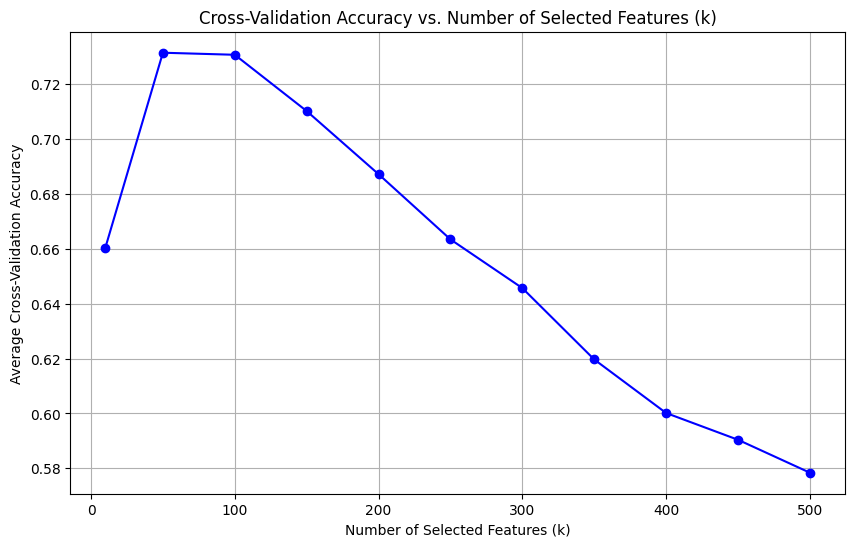

In [ ]:
## 4.1: Selecting Top k Features with SelectKBest
# To empirically choose the best 'k', we evaluate model performance across a range of k-values.
# For each value of k, we use SelectKBest (using the ANOVA F-test) to select the top features,
# then train a Logistic Regression model using 5-fold cross-validation.
# Finally, store the mean cross-validation accuracy for each k and then plot these values.


# Define a range of k values to tes.
k_values = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
cv_scores = []  # This will store the average cross-validation accuracy for each k

# Loop through different k values to determine how many features yield the best CV accuracy.
for k in k_values:
    pipeline_k = Pipeline([
        ('scaler', StandardScaler()),             # Step 1: Standardize features
        ('variance', VarianceThreshold(threshold=0.01)),  # Step 2: Remove low-variance features
        ('select_k', SelectKBest(score_func=f_classif, k=k)),  # Step 3: Select top k features
        ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))  # Baseline model
    ])

    # Evaluate the pipeline using 5-fold cross-validation on the training data.
    # cross_val_score returns an array of accuracy scores.
    scores = cross_val_score(pipeline_k, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    cv_scores.append(mean_score)
    #print(f"k = {k}: Mean CV Accuracy = {mean_score:.4f}")


# Plot the results to visualize the impact of different k values on model performance.
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='blue')
plt.title('Cross-Validation Accuracy vs. Number of Selected Features (k)')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
## 4.2: GridSearchCV with multiple classifiers
# Integrate hyperparameter tuning for both feature selection and classifier parameters.
# We'll compare Logistic Regression, Decision Tree, and Random Forests as potential classifiers.

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('select_k', SelectKBest(score_func=f_classif)),  # 'k' will be tuned
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))  # placeholder classifier
])

# Defined a parameter grid that tunes:
# - The number of features selected (k) - from prior step, it looks like 50 and 100 are the best
# - The classifier type and its parameters (using a decision tree or logistic regression)

#### Sections are commented out to reduce processing time. ####

param_grid = [
    # {
    #     'select_k__k': [50, 100], # Grid search will test both of these values
    #     'classifier': [LogisticRegression(max_iter=1000, solver='liblinear')],
    #     'classifier__C': [0.01, 0.1, 1, 10],
    #     'classifier__penalty': ['l1', 'l2']
    # },
    # {
    #     'select_k__k': [50, 100],
    #     'classifier': [DecisionTreeClassifier()],
    #     'classifier__max_depth': [None, 5, 10, 15],
    #     'classifier__min_samples_split': [2, 5, 10]
    # },
    { # Best Performer
        'select_k__k': [50, 100],
        'classifier': [RandomForestClassifier()],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__n_estimators': [10,25]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose = 0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('variance',
                                        VarianceThreshold(threshold=0.01)),
                                       ('select_k', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [None, 5, 10, 15],
                          'classifier__min_samples_split': [2, 5, 10],
                          'classifier__n_estimators': [10, 25],
                          'select_k__k': [50, 100]}],
             scoring='accuracy')

In [ ]:
# Print best parameters
print('Best parameters from GridSearchCV:\n', grid_search.best_params_, '\n')
print(f'Validation score: {grid_search.best_score_:.2%}')
print(f'Test score: {grid_search.score(X_test, y_test):.2%}')

Best parameters from GridSearchCV:
 {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 25, 'select_k__k': 100} 

Validation score: 89.75%
Test score: 91.20%


Best parameters from GridSearchCV:
> {'classifier': LogisticRegression(max_iter=1000, solver='liblinear'), 'classifier__C': 10, 'classifier__penalty': 'l1', 'select_k__k': 50}<br>
> Validation score: 73.64% <br>
> Test score: 75.60%
>
> {'classifier': DecisionTreeClassifier(), 'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'select_k__k': 50} <br>
> Validation score: 84.17%<br>
> Test score: 85.30%
>
> {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25, 'select_k__k': 100}
> Validation score: 89.70%<br>
> Test score: 90.70%

Conclusion: Random Forest provided best scores.

### **Step 5: Ensembling**

In [ ]:
##5: Ensembling Classifiers

# Below are best parameters for LR and DT from last step (excluding RF):

# Classifiers
lr = LogisticRegression(max_iter=1000, solver='liblinear',C=10,penalty='l1')
dt = DecisionTreeClassifier(max_depth = 10, min_samples_split = 10)

voting_clf = VotingClassifier(estimators=[('lr', lr), ('dt', dt)], voting = 'hard')

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('select_k', SelectKBest(score_func=f_classif, k = 50)), # k = 50 was found to be the best in all models
    ('voting', voting_clf)  # ensemble classifier
])

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
mean_score = scores.mean()

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('variance', VarianceThreshold(threshold=0.01)),
                ('select_k', SelectKBest(k=50)),
                ('voting',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=10,
                                                                  max_iter=1000,
                                                                  penalty='l1',
                                                                  solver='liblinear')),
                                              ('dt',
                                               DecisionTreeClassifier(max_depth=10,
                                                                      min_samples_split=10))]))])

In [ ]:
# Print results
print(f'Validation score: {mean_score}')
print(f'Test score: {pipeline.score(X_test, y_test):.2%}')

Validation score: 0.7901983729662077
Test score: 80.20%


Conclusion: Ensembling LR and DT is not as effective as RF.  

### **Step 6: Dimensionality Reduction**

In [ ]:
## 6.1: Dimensionality Reduction using PCA & LDA
# Try options for PCA and LDA in dimensionality reduction.
# Is it going to be more effective or more efficient than feature selection?

# First, how many features should we have for LDA?

# Make LDA model based on max n_components.
lda = LDA(n_components=len(y.unique())-1) # This is number of classes minus 1

# Fit training dataset to model.
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)

# Results
# print(lda.explained_variance_ratio_,'\n') # Prints variance of all 8 (max) components
print("About 90% of variance is contained in 6 components:\n", lda.explained_variance_ratio_[:6], '\n', "Sum of variance in top 6 components:", sum(lda.explained_variance_ratio_[:6]))

About 90% of variance is contained in 6 components:
 [0.40636128 0.19579623 0.11591451 0.07087435 0.06284954 0.05320031] 
 Sum of variance in top 6 components: 0.9049962150296326


Conclusion: We will have between 6-8 features for LDA.


In [ ]:
# 6.2: GridSearch will test PCA and LDA using LR, DT, & RF as classifiers.

pipeline = Pipeline([
    ("reduction", PCA()), # placeholder dimensionality reduction
    ('scaler', StandardScaler()),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))  # placeholder classifier
])

# Defined a parameter grid that tunes:
# - PCA n_components is set around k values from feature selection
# - LDA n_components is no less than 6 (contains at least 90% of variance) but no more than 8
# - The classifier type and its parameters

#### Sections are commented out to reduce processing time. ####

param_grid = [
    # {
    #     'reduction': [PCA()],
    #     'reduction__n_components': [25,50,75,100],
    #     'classifier': [LogisticRegression(max_iter=1000, solver='liblinear')],
    #     'classifier__C': [0.01, 0.1, 1, 10],
    #     'classifier__penalty': ['l1', 'l2']

    # },
    # {
    #     'reduction': [PCA()],
    #     'reduction__n_components': [25,50,75,100],
    #     'classifier': [DecisionTreeClassifier()],
    #     'classifier__max_depth': [None, 5, 10, 15],
    #     'classifier__min_samples_split': [2, 5, 10]

    # },
    # {
    #     'reduction': [LDA()],
    #     'reduction__n_components': [6, 7, 8],
    #     'classifier': [LogisticRegression(max_iter=1000, solver='liblinear')],
    #     'classifier__C': [0.01, 0.1, 1, 10],
    #     'classifier__penalty': ['l1', 'l2']
    # },
    # {
    #     'reduction': [LDA()],
    #     'reduction__n_components': [6, 7, 8],
    #     'classifier': [DecisionTreeClassifier()],
    #     'classifier__max_depth': [None, 5, 10, 15],
    #     'classifier__min_samples_split': [2, 5, 10]
    # },

    # {
    #     'reduction': [LDA()],
    #     'reduction__n_components': [6, 7, 8],
    #     'classifier': [RandomForestClassifier()],
    #     'classifier__n_estimators': [10,25],
    #     'classifier__max_depth': [None, 5, 10, 15],
    #     'classifier__min_samples_split': [2, 5, 10]
    # },
    { # Best performing
        'reduction': [PCA()],
        'reduction__n_components': [25,50,75,100],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10,25],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10]

    }
]

grid_search_red = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_red.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reduction', PCA()),
                                       ('scaler', StandardScaler()),
                                       ('variance',
                                        VarianceThreshold(threshold=0.01)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [None, 5, 10, 15],
                          'classifier__min_samples_split': [2, 5, 10],
                          'classifier__n_estimators': [10, 25],
                          'reduction': [PCA()],
                          'reduction__n_components': [25, 50, 75, 100]}],
             scoring='accuracy')

In [ ]:
# Print best parameters
print('Best parameters from GridSearchCV:\n', grid_search_red.best_params_, '\n')
print(f'Validation score: {grid_search_red.best_score_:.2%}')
print(f'Test score: {grid_search_red.score(X_test, y_test):.2%}')

Best parameters from GridSearchCV:
 {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25, 'reduction': PCA(), 'reduction__n_components': 25} 

Validation score: 80.19%
Test score: 81.00%


Best Parameters from PCA/LDA

**PCA (for LR and DT)**
> {'classifier': **DecisionTreeClassifier()**, 'classifier__max_depth': 15, 'classifier__min_samples_split': 10, 'reduction': **PCA()**, 'reduction__n_components': 25} <br>
Validation score: 77.29% <br>
Test score: 77.90%
>
**LDA (for LR and DT)**
> {'classifier': **LogisticRegression(max_iter=1000, solver='liblinear')**, 'classifier__C': 0.01, 'classifier__penalty': 'l2', 'reduction': **LinearDiscriminantAnalysis()**, 'reduction__n_components': 6} <br>
Validation score: 52.06% <br>
Test score: 59.80%

**PCA/LDA (for RF)**
> {'classifier': **RandomForestClassifier()**, 'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 25, 'reduction': **PCA()**, 'reduction__n_components': 25} <br>
Validation score: 80.17% <br>
Test score: 82.20%
>
> {'classifier': **RandomForestClassifier()**, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 25, 'reduction': **LinearDiscriminantAnalysis()**, 'reduction__n_components': 8} <br>
Validation score: 50.71% <br>
Test score: 56.60%

Conclusion: Dimensionality Reduction (PCA) brings n_components = 25, which could reduce processing time significantly.  However, we lose about 8% accuracy as a result with final accuracy at **82%.**

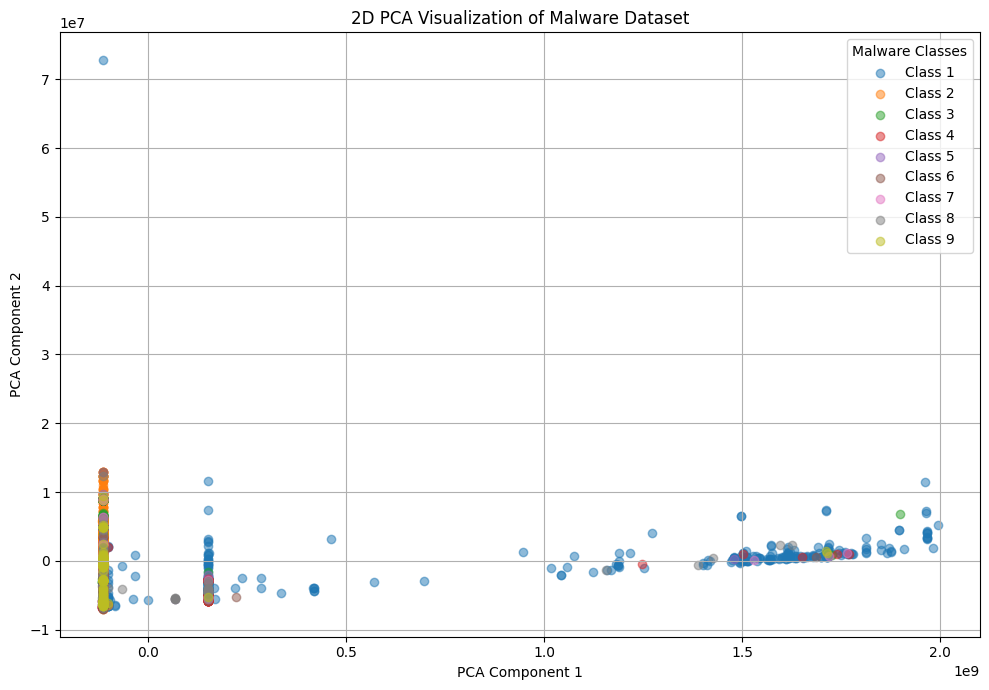

In [ ]:
# Reduce to 2 dimensions using PCA for visualization purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Plotting PCA results clearly
plt.figure(figsize=(10, 7))
classes = np.unique(y_train)
for malware_class in classes:
    plt.scatter(
        X_pca[y_train == malware_class, 0],
        X_pca[y_train == malware_class, 1],
        alpha=0.5,
        label=f'Class {malware_class}'
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Malware Dataset')
plt.legend(title='Malware Classes')
plt.grid(True)
plt.tight_layout()
plt.show()


Most malware classes overlap substantially. This indicates that many malware samples across different classes are similar when viewed from a simplified two-dimensional perspective.

This overlap explains why a simple linear model (e.g., logistic regression) may not achieve very high accuracy.
Complex classifiers like Random Forest are necessary because they handle such complexity and overlapping data better.

The large range of values on the PCA components axes indicates significant variance in a few dimensions. This confirms the importance of feature selection to remove redundant or noisy features—exactly why we applied VarianceThreshold and SelectKBest.

### **Step 7: Neural Network Classification**

In [ ]:
# Finally, we try using NNs to increase our classification accuracy.

# Some data preprocessing.
y = y - 1 # adjusts class labels by 1
num_classes = len(y.unique()) # number of classes for C
k = 100 # Best k value from RF model

# Ensures no dtype errors.
X = X.astype(np.float32)
y = y.astype(np.int32)

# Convert DataFrames to npArrays.
X = np.array(X.loc[:])
y = np.array(y)

# To filter out some of the useless features, we'll use SelectKBest again before inputing to NN.
feature_selector = SelectKBest(score_func=f_classif, k=k) #Parameters that gave the best RF accuracy.
X_best = feature_selector.fit_transform(X,y)

# Re-split training and test data.
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)

# Set up TensorDatasets and DataLoaders.
train_dataset = torch.utils.data.TensorDataset(torch.tensor(nn_X_train), torch.tensor(nn_y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(nn_X_test), torch.tensor(nn_y_test))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Assign parameters
N = len(train_dataset) # Number of training points
d = k # Number of features
C = num_classes # Number of classes

In [ ]:
# Define method for NN (huge credit to Professor Bastanlar's "Lecture 15 Neural Networks.ipynb")

def train_log_loss_network(model, train_loader, val_loader=None, epochs=50, device="cpu"):
  loss_fn = nn.CrossEntropyLoss() #CrossEntropy is another name for the Logistic Regression loss function.
  #loss_fn = nn.NLLLoss() #To employ negative log likelihood loss OR so-called Softmax loss

  #We need an optimizer! Adam is a good default one that works "well enough" for most problems
  #To tell Adam what to optimize, we give it the model's parameters - because thats what the learning will adjust
  optimizer = torch.optim.Adam(model.parameters())

  #Devices can be spcified by a string, or a special torch object
  #If it is a string, lets get the correct device
  if device.__class__ == str:
    device = torch.device(device)

  model.to(device)#Place the model on the correct compute resource
  for epoch in range(epochs):

    model = model.train()#Put our model in training mode
    running_loss = 0.0

    for inputs, labels in train_loader: #tqdm(train_loader):

      #Move the batch to the device we are using.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      y_pred = model(inputs)

      # Compute loss.
      loss = loss_fn(y_pred, labels.long())

      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its parameters
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)

    if val_loader is None:
      print("Loss after epoch {} is {}".format(epoch, running_loss))
    else:#Lets find out validation performance as we go!
      model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

      predictions = []
      targets = []

      for inputs, labels in test_loader:

        #Move the batch to the device we are using.
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        # Get predicted classes
        # y_pred will have a shape (Batch_size, C)
        #We are asking for which class had the largest response along dimension #1, the C dimension
        for pred in torch.argmax(y_pred, dim=1).cpu().numpy():
          predictions.append(pred)
        for l in labels.cpu().numpy():
          targets.append(l)

      #print("Network Accuracy: ", )
      print("Loss after epoch {} is {}. Accuracy: {}".format(epoch, running_loss, accuracy_score(predictions, targets)))

In [ ]:
# Define model for neural network (huge credit to Professor Bastanlar's "Lecture 15 Neural Networks.ipynb")
## Utilizes non-linearity along with regularization techniques, Batch-Normalization and Dropout.

n = d*2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # utilizes GPU

model = torch.nn.Sequential(
  #First hidden layer
  nn.Linear(d, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Second
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Third
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Fourth
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Output!
  nn.Linear(n, C),
)
train_log_loss_network(model, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 7083.779497504234. Accuracy: 0.575
Loss after epoch 1 is 5822.1741107702255. Accuracy: 0.615
Loss after epoch 2 is 5428.6330889463425. Accuracy: 0.621
Loss after epoch 3 is 5114.088410615921. Accuracy: 0.594
Loss after epoch 4 is 5059.2572058439255. Accuracy: 0.612
Loss after epoch 5 is 4885.6844138503075. Accuracy: 0.618
Loss after epoch 6 is 4820.5656863451. Accuracy: 0.625
Loss after epoch 7 is 4796.845664381981. Accuracy: 0.609
Loss after epoch 8 is 4699.177223682404. Accuracy: 0.608
Loss after epoch 9 is 4730.145028471947. Accuracy: 0.651
Loss after epoch 10 is 4708.018985748291. Accuracy: 0.652
Loss after epoch 11 is 4643.554289340973. Accuracy: 0.634
Loss after epoch 12 is 4601.680496811867. Accuracy: 0.643
Loss after epoch 13 is 4604.4844735860825. Accuracy: 0.651
Loss after epoch 14 is 4595.392115712166. Accuracy: 0.663
Loss after epoch 15 is 4586.408378243446. Accuracy: 0.673
Loss after epoch 16 is 4523.775648713112. Accuracy: 0.658
Loss after epoch 17 i

Conclusion: Neural network, using non-linearity and regularization techniques, accomplished an accuracy of only about **66%.**

### **Step 8: Final Evaluation of The Tuned Models**

In [ ]:
# Make predictions using best models from GridSearchCV and evaluate performance.
for model in [('Feature Selection', grid_search), ('Dimensionality Reduction', grid_search_red)]:
    start = time.time()
    y_pred = model[1].predict(X_test)
    end = time.time()

# Print reports
    print(f"\n=== {model[0]}: Final Model Performance ===\n")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f'\nProcessing Time (sec): {end-start:.4f}')


=== Feature Selection: Final Model Performance ===

Classification Report:

              precision    recall  f1-score   support

           1       0.86      0.95      0.90       138
           2       0.93      0.95      0.94       232
           3       0.92      0.97      0.94       268
           4       0.86      0.81      0.83        37
           5       0.83      0.42      0.56        12
           6       0.89      0.74      0.81        69
           7       1.00      0.85      0.92        34
           8       0.91      0.85      0.88       110
           9       0.95      0.90      0.92       100

    accuracy                           0.91      1000
   macro avg       0.91      0.83      0.86      1000
weighted avg       0.91      0.91      0.91      1000

Confusion Matrix:
[[131   2   2   0   0   2   0   1   0]
 [  4 221   2   0   0   2   0   3   0]
 [  1   4 261   0   1   1   0   0   0]
 [  3   1   1  30   0   0   0   1   1]
 [  1   1   5   0   5   0   0   0   0]
 [  3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Final Conclusions:**
> To find the best supervised classification model, we tried the following classification models:
- Logistic regression (LR) and decision trees (DT)
- Ensembling LR and DT
- Random Forest <br>
- Neural Network

> We used GridSearchCV to do the following:
- Test various regularization strengths (C, tree depths, etc.)
- Used five-fold cross validation for robust models.<br>

> We also tried to remove unnecessary features using feature selection (ANOVA F-value) and dimensionality reduction (PCA and LDA). <br>

> We came to the below conclusions:
- <u>Best Classifier:</u> Random Forest (91% accurate)
- <u>Feature Selection</u> worked best (in accuracy and processing time) to reduce number of features.


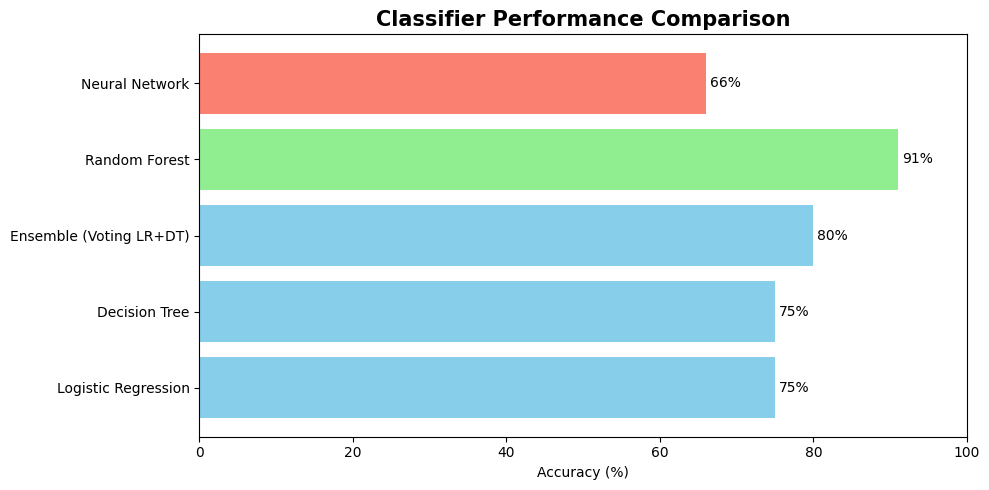

In [ ]:
# Define classifiers and performance explicitly
classifiers = [
    ('Logistic Regression', 75),
    ('Decision Tree', 75),
    ('Ensemble (Voting LR+DT)', 80),
    ('Random Forest', 91),
    ('Neural Network', 66)  # explicitly included here
]

# Plot performance comparison explicitly
names, accuracies = zip(*classifiers)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(names, accuracies, color=['skyblue', 'skyblue', 'skyblue', 'lightgreen', 'salmon'])

# Annotate bars clearly
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}%',
                xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(3, 0),
                textcoords='offset points',
                ha='left', va='center', fontsize=10)

# Formatting for clarity
ax.set_xlabel('Accuracy (%)')
ax.set_xlim(0, 100)
ax.set_title('Classifier Performance Comparison', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()